In [1]:
# importing packages
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import os
import random
import shutil
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
# Define dataset directories
dataset_dir = "/content/drive/MyDrive/Colab Notebooks/Bird Species Classification/Dataset Yoezer"
train_dir = "/content/drive/MyDrive/Colab Notebooks/Bird Species Classification/Train_dataset"
validation_dir = "/content/drive/MyDrive/Colab Notebooks/Bird Species Classification/Validate_dataset"


In [6]:
# List all subdirectories (each corresponding to a bird species)
subdirectories = [subdir for subdir in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, subdir))]

# Create train and validation directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)

# Specify the ratio of data to use for validation (e.g., 20%)
validation_ratio = 0.2

# Loop through each bird species subdirectory
for subdir in subdirectories:
    # Create subdirectories in train and validation directories
    os.makedirs(os.path.join(train_dir, subdir), exist_ok=True)
    os.makedirs(os.path.join(validation_dir, subdir), exist_ok=True)

    # List all image files in the current bird species subdirectory
    image_files = os.listdir(os.path.join(dataset_dir, subdir))

    # Split the images into training and validation sets
    train_images, validation_images = train_test_split(image_files, test_size=validation_ratio, random_state=42)

    # Move images to the respective train and validation subdirectories
    for image in train_images:
        source_path = os.path.join(dataset_dir, subdir, image)
        destination_path = os.path.join(train_dir, subdir, image)
        shutil.copy(source_path, destination_path)

    for image in validation_images:
        source_path = os.path.join(dataset_dir, subdir, image)
        destination_path = os.path.join(validation_dir, subdir, image)
        shutil.copy(source_path, destination_path)

In [7]:
# Data augmentation for the training dataset
#The train_datagen is an instance of ImageDataGenerator
# Data augmentation techniques are applied to increase the diversity of the data
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Rescale pixel values to [0, 1]
    rotation_range=20,  # Randomly rotate images
    width_shift_range=0.2,  # Randomly shift images horizontally
    height_shift_range=0.2,  # Randomly shift images vertically
    horizontal_flip=True,  # Randomly flip images horizontally
    zoom_range=0.2  # Randomly zoom in on images
)

Preprocessing for Validation dataset

In [8]:

# Validation data should only be rescaled
validation_datagen = ImageDataGenerator(rescale=1./255)


In [9]:
#These generators allow you to load and preprocess data on the fly, making it efficient for training
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(299, 299),  # InceptionV3 input size
    batch_size= 32,
    class_mode='categorical'
)


Found 1020 images belonging to 17 classes.


In [10]:
# Create data generators for training and validation
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(299, 299),
    batch_size= 32,
    class_mode='categorical'
)


Found 4080 images belonging to 17 classes.


In [11]:
# load InceptionV3 model with pre-trained weights (include_top=False to exclude final fully connected layer)
base_model = InceptionV3(weights='imagenet', include_top=False)


87910968/87910968 [==============================] - 0s 0us/step


In [12]:
# Add custom classification layers on top of InceptionV3
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

In [13]:
# Freeze the layers in the base model
#This means that these layers won't be updated during training.
for layer in base_model.layers:
    layer.trainable = False

In [14]:
# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

In [15]:
# Freeze InceptionV3 layers (optional)
for layer in base_model.layers:
    layer.trainable = False

In [16]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [17]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,  # You can adjust the number of epochs
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

Epoch 1/10
128/128 [==============================] - 167s 1s/step - loss: 1.5226 - accuracy: 0.6255 - val_loss: 0.7889 - val_accuracy: 0.8363
Epoch 2/10
128/128 [==============================] - 142s 1s/step - loss: 0.6582 - accuracy: 0.8368 - val_loss: 0.5167 - val_accuracy: 0.8657
Epoch 3/10
128/128 [==============================] - 142s 1s/step - loss: 0.4718 - accuracy: 0.8804 - val_loss: 0.4195 - val_accuracy: 0.8912
Epoch 4/10
128/128 [==============================] - 142s 1s/step - loss: 0.4094 - accuracy: 0.8853 - val_loss: 0.3515 - val_accuracy: 0.9059
Epoch 5/10
128/128 [==============================] - 139s 1s/step - loss: 0.3512 - accuracy: 0.8973 - val_loss: 0.3513 - val_accuracy: 0.8951
Epoch 6/10
128/128 [==============================] - 136s 1s/step - loss: 0.3013 - accuracy: 0.9147 - val_loss: 0.3109 - val_accuracy: 0.9157
Epoch 7/10
128/128 [==============================] - 138s 1s/step - loss: 0.2812 - accuracy: 0.9260 - val_loss: 0.2912 - val_accuracy: 0.9127

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, None, None, 32)       864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, None, None, 32)       96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, None, None, 32)       0         ['batch_normalization[0][0

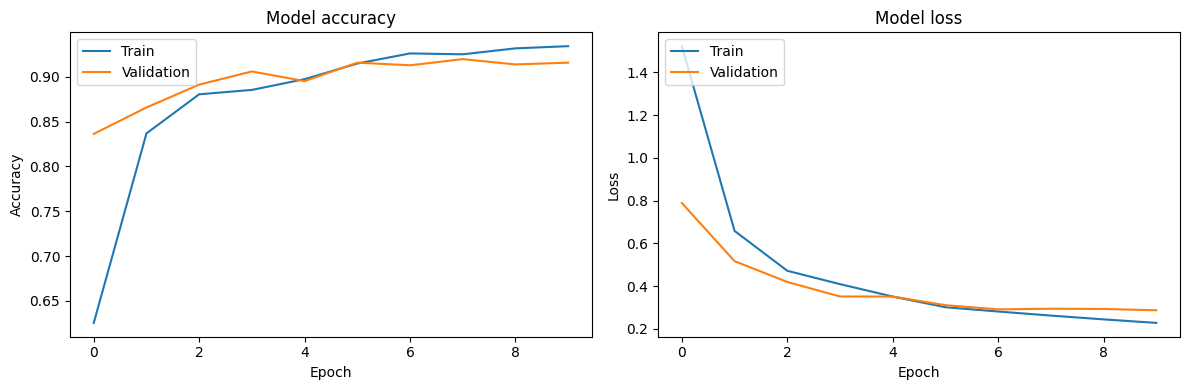

In [19]:
import matplotlib.pyplot as plt

def plot_training_curves(history):
    plt.figure(figsize=(12, 4))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

plot_training_curves(history)

In [20]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
predictions = model.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes


32/32 [==============================] - 12s 335ms/step


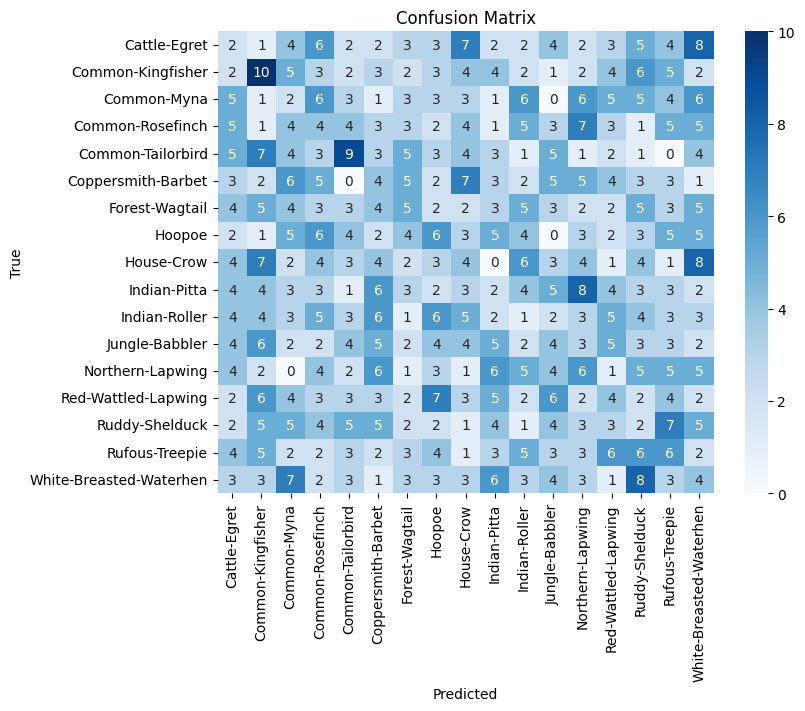

                         precision    recall  f1-score   support

           Cattle-Egret       0.03      0.03      0.03        60
      Common-Kingfisher       0.14      0.17      0.15        60
            Common-Myna       0.03      0.03      0.03        60
       Common-Rosefinch       0.06      0.07      0.06        60
      Common-Tailorbird       0.17      0.15      0.16        60
     Coppersmith-Barbet       0.07      0.07      0.07        60
         Forest-Wagtail       0.10      0.08      0.09        60
                 Hoopoe       0.10      0.10      0.10        60
             House-Crow       0.07      0.07      0.07        60
           Indian-Pitta       0.04      0.03      0.03        60
          Indian-Roller       0.02      0.02      0.02        60
         Jungle-Babbler       0.07      0.07      0.07        60
       Northern-Lapwing       0.10      0.10      0.10        60
    Red-Wattled-Lapwing       0.07      0.07      0.07        60
         Ruddy-Shelduck 

In [21]:
#After training, the model is evaluated on the validation data
confusion = confusion_matrix(true_classes, predicted_classes)

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=validation_generator.class_indices.keys(), yticklabels=validation_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print a classification report
print(classification_report(true_classes, predicted_classes, target_names=validation_generator.class_indices.keys()))

In [22]:
# Save the model
model.save("/content/drive/MyDrive/Colab Notebooks/Bird Species Classification/BC_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
